# Create Submission File for Kaggle

### Load Test Data

In [6]:
from src.data.datasets.data_loader import get_loader
import numpy as np

loader = get_loader(dataset_type="test", use_cached=True)
data = loader.processed_data

In [7]:
PATIENT = "p04"

data[PATIENT].keys()

dict_keys(['p04_24894', 'p04_24880', 'p04_24857', 'p04_24843', 'p04_24738', 'p04_24704', 'p04_24710', 'p04_24923', 'p04_24937', 'p04_24936', 'p04_24922', 'p04_24711', 'p04_24705', 'p04_24739', 'p04_24842', 'p04_24856', 'p04_24881', 'p04_24895', 'p04_24883', 'p04_24897', 'p04_24840', 'p04_24698', 'p04_24854', 'p04_24868', 'p04_24713', 'p04_24707', 'p04_24934', 'p04_24920', 'p04_24908', 'p04_24909', 'p04_24921', 'p04_24935', 'p04_24706', 'p04_24712', 'p04_24869', 'p04_24855', 'p04_24699', 'p04_24841', 'p04_24896', 'p04_24882', 'p04_24886', 'p04_24892', 'p04_24879', 'p04_24845', 'p04_24851', 'p04_24689', 'p04_24716', 'p04_24702', 'p04_24919', 'p04_24931', 'p04_24925', 'p04_24924', 'p04_24930', 'p04_24918', 'p04_24703', 'p04_24717', 'p04_24688', 'p04_24850', 'p04_24844', 'p04_24878', 'p04_24893', 'p04_24887', 'p04_24891', 'p04_24885', 'p04_24852', 'p04_24846', 'p04_24701', 'p04_24715', 'p04_24729', 'p04_24926', 'p04_24932', 'p04_24933', 'p04_24927', 'p04_24728', 'p04_24714', 'p04_24700', '

In [8]:
row1 = data[PATIENT]['p04_24894']

In [17]:
# Split up data into day and night
loader = get_loader(dataset_type="train", use_cached=True)

train_df = loader.train_data[loader.train_data["p_num"] == PATIENT]
test_df = loader.validation_data[loader.validation_data["p_num"] == PATIENT]

In [10]:
# import pandas as pd
from src.tuning.benchmark import impute_missing_values


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]
    # p_df.set_index("datetime", inplace=True)
    # p_df = p_df.asfreq('5T', method='pad')

    # Reduce features
    y_feature = ["bg-0:00"]
    x_features = [
        # "hr-0:00",
        "steps-0:00",
        # "cals-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X

In [18]:
y_test, X_test = reduce_features(row1)

In [19]:
y_test

,bg-0:00
0,10.9
1,11.0
2,11.0
3,11.1
4,11.4
...,...
67,14.2
68,14.2
69,14.1
70,13.0


In [21]:
X_test

,steps-0:00,cob,carb_availability,insulin_availability,iob
0,0.0,0.000000,0.000000,0.000000,0.062500
1,0.0,0.000000,0.000000,0.000110,0.124989
2,0.0,0.000000,0.000000,0.000608,0.187304
3,0.0,0.000000,0.000000,0.001577,0.249146
4,0.0,0.000000,0.000000,0.003002,0.310192
...,...,...,...,...,...
67,0.0,36.545361,20.349122,0.633835,12.003080
68,0.0,34.029504,19.759067,0.655609,11.616981
69,0.0,31.595252,19.021631,0.669417,11.218125
70,0.0,29.258769,18.180206,0.676447,10.811675


In [22]:
y_train, X_train = reduce_features(train_df)

In [28]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon

TIME_STEP_SIZE = (
    pd.to_datetime(row1["datetime"]).iloc[1] - pd.to_datetime(row1["datetime"]).iloc[0]
).components.minutes

if TIME_STEP_SIZE != 5 and TIME_STEP_SIZE != 15:
    error = """
    First time step is not 5 or 15 minutes. Look at the most common time step size.
    """

HOURS_TO_PREDICT = 1
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE

fh = ForecastingHorizon( np.arange(1, NUM_STEPS + 1), is_relative=True)


## Tiny Time Mixer Forecast

In [26]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster
import numpy as np
import pandas as pd

# loss_callback = LossPlottingCallback()

current_time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

training_samples = len(y_train)

BATCH_SIZE = 128
STEPS_PER_EPOCH = training_samples // BATCH_SIZE
NUM_TRAIN_EPOCH = 2  # How many epochs to run
SAVE_EVERY_EPOCH = 100  # How many epochs to save
model = "TinyTimeMixer"


interval = "05mins" if TIME_STEP_SIZE == 5 else "15mins"
dir_path = f"../../src/models/ttm/{interval}/{PATIENT}/{current_time}"

ttm_forecaster = TinyTimeMixerForecaster(
    config={
        "context_length": (60 // TIME_STEP_SIZE) * 18,  # 18 hours of context length
        "prediction_length": (60 // TIME_STEP_SIZE) * 6,  # 6 hours of prediction length
    },
    training_args={
        "num_train_epochs": NUM_TRAIN_EPOCH,
        "output_dir": dir_path,
        "use_cpu": False,
        "per_device_train_batch_size": BATCH_SIZE,
        "save_steps": STEPS_PER_EPOCH * SAVE_EVERY_EPOCH,
        # "callbacks": [],  # Add the callback here, why is this not working?
    },
)

print("selected interval: ", interval)
print(f"Training samples: {training_samples}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Every epoch has: {STEPS_PER_EPOCH} batches (or steps)")
print(f"Saving a checkpoint every {STEPS_PER_EPOCH * SAVE_EVERY_EPOCH} steps")

selected interval:  05mins
Training samples: 19018
Batch size: 128
Every epoch has: 148 batches (or steps)
Saving a checkpoint every 14800 steps


In [27]:
ttm_forecaster.fit(y=y_train, X=X_train, fh=fh)

/Users/juliazhu/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/sktime/forecasting/ttm.py:374: UserWarning: Invalid configuration detected. The provided values do not satisfy the required condition:
context_length / num_patches == patch_length == patch_stride
Provided configuration:
- context_length: 216
- num_patches: 8
- patch_length: 64
- patch_stride: 64
Configuration has been automatically updated to:
- context_length: 216
- num_patches: 8
- patch_length: 27
- patch_stride: 27
  warn(msg)


{'train_runtime': 32.3635, 'train_samples_per_second': 922.459, 'train_steps_per_second': 7.23, 'train_loss': 5.35264391776843, 'epoch': 2.0}


TinyTimeMixerForecaster(config={'context_length': 216, 'prediction_length': 72},
                        training_args={'num_train_epochs': 2,
                                       'output_dir': '../../src/models/ttm/05mins/p04/2025-07-10_17-58-59',
                                       'per_device_train_batch_size': 128,
                                       'save_steps': 14800, 'use_cpu': False})

In [30]:

ttm_forecaster.update(y=y_test, X=X_test, update_params=False)

TinyTimeMixerForecaster(config={'context_length': 216, 'prediction_length': 72},
                        training_args={'num_train_epochs': 2,
                                       'output_dir': '../../src/models/ttm/05mins/p04/2025-07-10_17-58-59',
                                       'per_device_train_batch_size': 128,
                                       'save_steps': 14800, 'use_cpu': False})

In [39]:
y_pred_ttm = ttm_forecaster.predict(fh=fh) 
y_pred_ttm

,bg-0:00
72,6.875024
73,6.764345
74,6.881971
75,6.911303
76,6.789516
77,6.703050
78,7.023318
79,6.897242
80,6.863798
81,6.806015


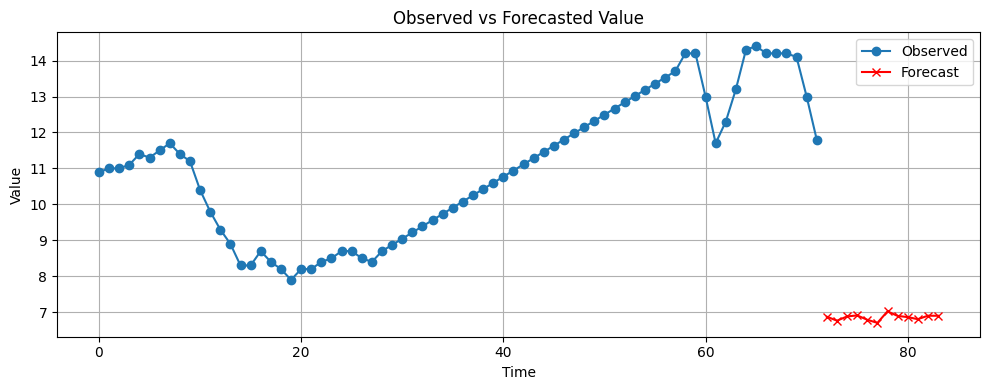

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Observed', marker='o')
plt.plot(y_pred_ttm, label='Forecast', marker='x', color='red')
plt.title("Observed vs Forecasted Value")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### NaiveForecaster

In [32]:
from src.tuning.load_estimators import load_all_forecasters, get_estimator

# This loads all sktime forecasters to be accessible by their class name -> don't need to run again
forecasters = load_all_forecasters()

forecaster_class = get_estimator(forecasters, "NaiveForecaster")
naive_forecaster = forecaster_class(strategy="last")
naive_forecaster.fit(y=y_test, X=X_test, fh=fh)

NaiveForecaster()

In [37]:
y_pred_naive = naive_forecaster.predict(fh=fh)

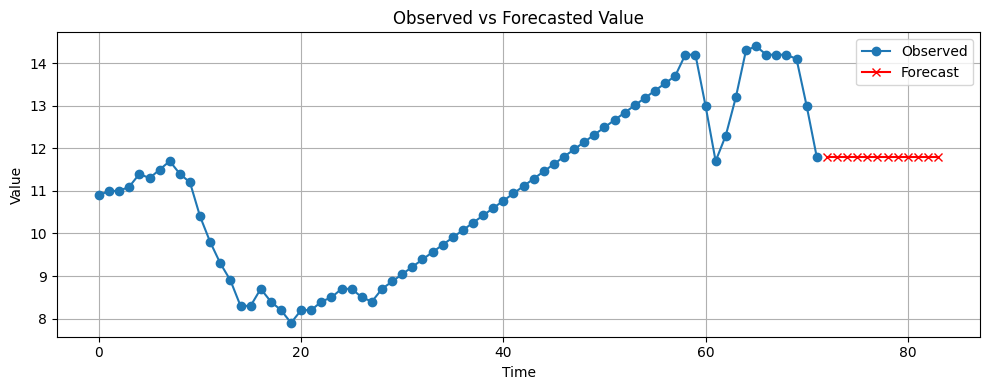

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Observed', marker='o')
plt.plot(y_pred_naive, label='Forecast', marker='x', color='red')
plt.title("Observed vs Forecasted Value")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### script to loop through all test data rows

In [41]:
from src.tuning.load_estimators import load_all_forecasters, get_estimator
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import os

# This loads all sktime forecasters to be accessible by their class name -> don't need to run again
forecasters = load_all_forecasters()


def create_submission_file(
    patient_dfs, model, params={}, fh=np.arange(1, 13), save_path="."
):
    results = []

    for pid in tqdm(patient_dfs, desc="Patients"):
        for row_id in tqdm(patient_dfs[pid], desc=f"Rows for {pid}", leave=False):
            df = patient_dfs[pid][row_id]
            try:
                y, X = reduce_features(df)

                forecaster_class = get_estimator(forecasters, model)
                forecaster = forecaster_class(**params)

                forecaster.fit(y=y, X=X, fh=fh)
                y_pred = forecaster.predict(fh=fh)

                predicted_value = y_pred.iloc[-1].item()

                results.append({"id": row_id, "bg+1:00": predicted_value})

            except Exception as e:
                print(f"Failed to forecast {row_id} ({pid}): {e}")

    # save to file
    results_df = pd.DataFrame(results)
    filename = f"{model}_submission.csv"

    os.makedirs(save_path, exist_ok=True)
    file_path = os.path.join(save_path, filename)

    results_df.to_csv(file_path, index=False)
    return results_df

In [42]:
create_submission_file(
    data,
    "NaiveForecaster",
    {"strategy": "last"},
    save_path="../competition_submission",
)

Patients:   0%|          | 0/15 [00:00<?, ?it/s]

Rows for p19:   0%|          | 0/246 [00:00<?, ?it/s]

Rows for p21:   0%|          | 0/236 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from src.utils.config_loader import load_yaml_config

config_path = "../../src/models/configs/TinyTimeMixerForecaster.yaml"
params = load_yaml_config(config_path)

create_submission_file(
    data,
    "TinyTimeMixerForecaster",
    params,
    save_path="../competition_submission",
)

Rows for p01:   0%|          | 0/244 [00:00<?, ?it/s]

,id,bg+1:00
0,p01_8459,11.307776
1,p01_8460,5.439600
2,p01_8461,7.188557
3,p01_8462,8.037812
4,p01_8463,6.701509
...,...,...
239,p01_8698,5.816570
240,p01_8699,5.001166
241,p01_8700,14.397934
242,p01_8701,12.422853
